# The fast spectral method

In [1]:
import os
os.chdir('../src')

In [2]:
%matplotlib inline
import numpy as np
import cupy as cp
from math import pi
from scipy import special
import matplotlib.pyplot as plt
import pyfftw

from collision.fast_spec_col_3d import FastSpectralCollison3D
# from src.collision.direct_col_3d import DirectCol3D
from utility import get_config, RK3

In [3]:
def isotropic_f(v):
    t = 6.5
    K = 1 - np.exp(-t/6)
    v_norm = v[:,None,None]**2 + v[:,None]**2 + v**2
    return 1/(2*(2*pi*K)**(3/2))*np.exp(-(v_norm)/(2*K))*((5*K-3)/K+(1-K)/(K**2)*(v_norm))

def extQ(v):
    t = 6.5
    K = 1 - np.exp(-t/6)
    dK = np.exp(-t/6)/6
    v_norm = v[:,None,None]**2 + v[:,None]**2 + v**2
    df = (-3/(2*K)+(v_norm)/(2*K**2))*isotropic_f(v) + 1/(2*(2*pi*K)**(3/2))*np.exp(-v_norm/(2*K))*(
    3/(K**2)+(K-2)/(K**3)*v_norm)
    return df*dK

def anisotropic_f(v):
    return 0.8*pi**(-1.5)*(np.exp(-16**(1/3)*((v-2)[:,None,None]**2 + (v-2)[:,None]**2 + (v-2)**2)) 
                           + np.exp(-(v+0.5)[:,None,None]**2-(v+0.5)[:,None]**2 - (v+0.5)**2))

def maxwellian(v, rho, u, T):
    v_u = ((v - u[0])**2)[:,None,None] + ((v - u[1])**2)[:,None] + (v - u[2])**2
    return rho/(2*pi*T)**(3/2)*np.exp(-v_u/(2*T))

In [4]:
config_3D = get_config('./configs/config_3D.json')
Q = FastSpectralCollison3D(config_3D)

In [5]:
%time Q_sep = Q.col_sep(isotropic_f(Q.v))/(4*pi)
np.max(np.abs(Q_sep - extQ(Q.v)))

CPU times: user 1.39 s, sys: 1.01 s, total: 2.41 s
Wall time: 656 ms


2.6901755125239917e-06

In [21]:
from configparser import ConfigParser
from collisionV2.spectral_mesh import SpectralMesh
from collisionV2.inelastic_collisions import FSInelasticVHSCollision

cfg = ConfigParser()
cfg.read('./collisionV2/vhs-3d.ini')
vm = SpectralMesh(cfg)
Q_new = FSInelasticVHSCollision(cfg, vm)
Q_new._gamma

Number of cells in vi: 32.
Velocity domain: (-8.82842712474619, 8.82842712474619).
Finished collision model precomputation.


1.0

In [22]:
%time Q3 = Q_new(isotropic_f(Q.v), device='gpu')
np.max(np.abs(Q3 - extQ(Q.v)))

CPU times: user 21.1 ms, sys: 383 µs, total: 21.5 ms
Wall time: 19.4 ms


0.06345631628259066

In [16]:
def T(t, e, eps, T_0):
    return (T_0 - 8*eps/(1-e**2))*np.exp(-(1-e**2)*t/4) + 8*eps/(1-e**2)

In [17]:
M = lambda v: maxwellian(v, 1, (0.5, -0.5, 0), 2)

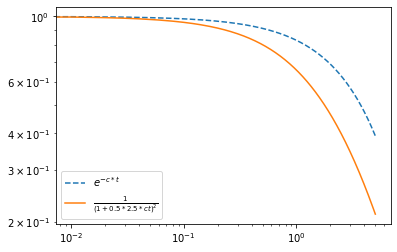

In [18]:
t = np.arange(0., 5.009, 0.01)

e = 0.5
c = (1 - e**2)/4
E0 = 1

fig, ax = plt.subplots()
ax.loglog(t, E0*np.exp(-c*t), '--', label=r'$e^{-c*t}$')
ax.loglog(t, 1/(1/np.sqrt(E0) + 0.5*2.5*c*t)**2, label=r'$\frac{1}{(1+0.5*2.5*c t)^2}$')
ax.legend()
fig.savefig('test1.pdf')

In [23]:
from utility import RK3
from tqdm.notebook import tnrange
from math import pi

tau = 0.1
# Set up parameters
dt = 0.01
t = 0

# Initialize
# f = bkw_f(Q.v, 0.)
# f = maxwellian(Q.v, 8.0)
# f = flat(Q.v, 8.)
f = M(Q.v)
fs = [f]
ts = [t]

ini = {'density': np.sum(f)*Q.dv**3,
       'energy': 0.5*np.sum(f*Q.v_norm)*Q.dv**3
      }

E0 = ini['energy']
rho_0 = ini['density']

print(ini)

col = lambda x, y: Q_new(x, heat_bath=y, device='gpu')

for _ in tnrange(1000):
    f = RK3(f, col, tau, dt)
    t += dt
    fs.append(f)
    ts.append(t)
    
# print("Check whether it converges to equilibruim: {}".format(norm2(fs[-2] - fs[-1])))

end = {'density': np.sum(f)*Q.dv**3,
       'energy': 0.5*np.sum(f*Q.v_norm)*Q.dv**3
      }

print(end)

{'density': 0.9999999965144858, 'energy': 3.249999846457743}



{'density': 1.0001748514504007, 'energy': 1.002370301382282}


In [13]:
%%time
E_gamma_0 = [2]
for t in range(1,1001):
#     f = np.real(Q.ifft3(f_hat[t]))
    E_gamma_0.append(0.5*np.sum(fs[t]*Q.v_norm)*Q.dv**3)

CPU times: user 92.4 ms, sys: 32.1 ms, total: 125 ms
Wall time: 122 ms


In [20]:
%%time
E_gamma_05 = [2]
for t in range(1,1001):
#     f = np.real(Q.ifft3(f_hat[t]))
    E_gamma_05.append(0.5*np.sum(fs[t]*Q.v_norm)*Q.dv**3)

CPU times: user 109 ms, sys: 52.3 ms, total: 161 ms
Wall time: 159 ms


In [24]:
%%time
E_gamma_1 = [2]
for t in range(1,1001):
#     f = np.real(Q.ifft3(f_hat[t]))
    E_gamma_1.append(0.5*np.sum(fs[t]*Q.v_norm)*Q.dv**3)

CPU times: user 76.3 ms, sys: 19 ms, total: 95.3 ms
Wall time: 93.5 ms


In [30]:
T_gamma_0 = (np.asarray(E_gamma_0)*2 - 0.5) / 3
T_gamma_05 = (np.asarray(E_gamma_05)*2 - 0.5) / 3
T_gamma_1 = (np.asarray(E_gamma_1)*2 - 0.5) / 3

T_gamma_0[0] = 2
T_gamma_05[0] = 2
T_gamma_1[0] = 2

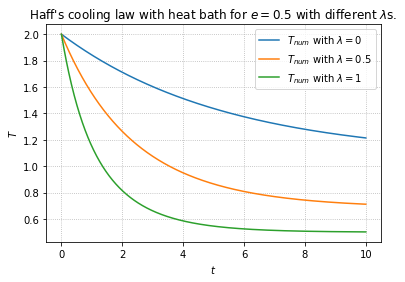

In [36]:
t = np.arange(0., 10.009, 0.01)


fig, ax = plt.subplots()

ax.plot(t, np.asarray(T_gamma_0), label=r'$T_{num}$ with $\lambda=0$')
ax.plot(t, np.asarray(T_gamma_05), label=r'$T_{num}$ with $\lambda=0.5$')
ax.plot(t, np.asarray(T_gamma_1), label=r'$T_{num}$ with $\lambda=1$')
ax.set_xlabel('$t$')
ax.set_ylabel('$T$')
ax.set_title('Haff\'s cooling law with heat bath for $e=0.5$ with different $\lambda$s.')
ax.legend()
ax.grid(which='both',linestyle=':')
plt.savefig('../reports/haff_var_lambda_heat.pdf')
plt.show()

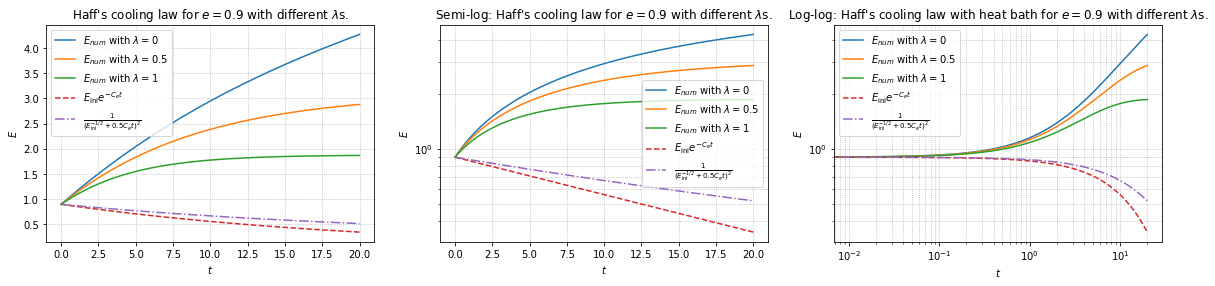

In [17]:
t = np.arange(0., 20.009, 0.01)

e = 0.9
ce = (1 - e**2)/4
fig, ax = plt.subplots(1, 3, figsize=(20,4))
ax[0].plot(t, np.asarray(E_gamma_0), label=r'$E_{num}$ with $\lambda=0$')
ax[0].plot(t, np.asarray(E_gamma_05),label=r'$E_{num}$ with $\lambda=0.5$')
ax[0].plot(t, np.asarray(E_gamma_1),label=r'$E_{num}$ with $\lambda=1$')
ax[0].plot(t, 0.9*np.exp(-ce*t), '--', label=r'$E_{\mathrm{ini}} e^{-C_e t}$')
ax[0].plot(t, 1/(1/np.sqrt(0.9) + 0.5*np.sqrt(2)/2*ce*t)**2, '-.', label=r'$\frac{1}{(E_{\mathrm{ini}}^{-1/2} + 0.5C_e t)^2}$')
ax[0].set_xlabel('$t$')
ax[0].set_ylabel('$E$')
ax[0].set_title('Haff\'s cooling law for $e=0.9$ with different $\lambda$s.')
# ax[0].set_xlim(0, 12.5)
ax[0].legend()
ax[0].grid(which='both',linestyle=':')

ax[1].semilogy(t, np.asarray(E_gamma_0), label=r'$E_{num}$ with $\lambda=0$')
ax[1].semilogy(t, np.asarray(E_gamma_05),label=r'$E_{num}$ with $\lambda=0.5$')
ax[1].semilogy(t, np.asarray(E_gamma_1),label=r'$E_{num}$ with $\lambda=1$')
ax[1].semilogy(t, 0.9*np.exp(-ce*t), '--', label=r'$E_{\mathrm{ini}} e^{-C_e t}$')
ax[1].semilogy(t, 1/(1/np.sqrt(0.9) + 0.5*np.sqrt(2)/2*ce*t)**2, '-.', label=r'$\frac{1}{(E_{\mathrm{ini}}^{-1/2} + 0.5C_e t)^2}$')
ax[1].set_xlabel('$t$')
ax[1].set_ylabel('$E$')
ax[1].set_title('Semi-log: Haff\'s cooling law for $e=0.9$ with different $\lambda$s.')
ax[1].legend()
ax[1].grid(which='both',linestyle=':')

ax[2].loglog(t, np.asarray(E_gamma_0), label=r'$E_{num}$ with $\lambda=0$')
ax[2].loglog(t, np.asarray(E_gamma_05),label=r'$E_{num}$ with $\lambda=0.5$')
ax[2].loglog(t, np.asarray(E_gamma_1),label=r'$E_{num}$ with $\lambda=1$')
ax[2].loglog(t, 0.9*np.exp(-ce*t), '--', label=r'$E_{\mathrm{ini}} e^{-C_e t}$')
ax[2].loglog(t, 1/(1/np.sqrt(0.9) + 0.5*np.sqrt(2)/2*ce*t)**2, '-.', label=r'$\frac{1}{(E_{\mathrm{ini}}^{-1/2} + 0.5C_e t)^2}$')
ax[2].set_xlabel('$t$')
ax[2].set_ylabel('$E$')
ax[2].set_title('Log-log: Haff\'s cooling law with heat bath for $e=0.9$ with different $\lambda$s.')
ax[2].legend()
ax[2].grid(which='both',linestyle=':')
plt.savefig('../reports/test_heat.pdf')
plt.show()

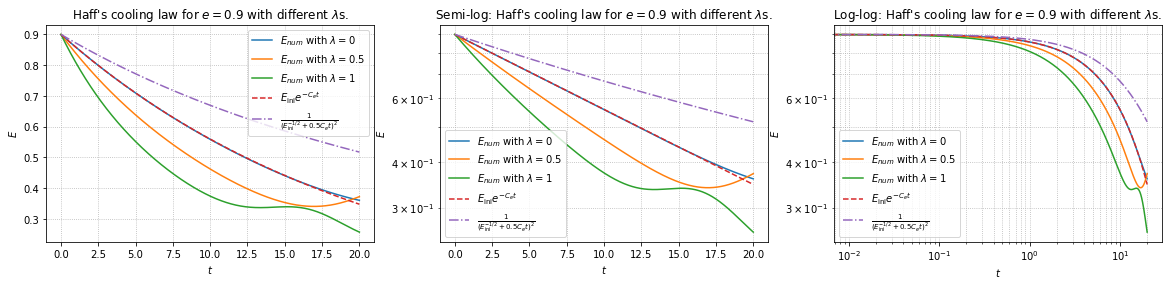

In [47]:
t = np.arange(0., 20.009, 0.01)

e = 0.9
ce = (1 - e**2)/4
fig, ax = plt.subplots(1, 3, figsize=(20,4))
ax[0].plot(t, np.asarray(E_gamma_0), label=r'$E_{num}$ with $\lambda=0$')
ax[0].plot(t, np.asarray(E_gamma_05),label=r'$E_{num}$ with $\lambda=0.5$')
ax[0].plot(t, np.asarray(E_gamma_1),label=r'$E_{num}$ with $\lambda=1$')
ax[0].plot(t, 0.9*np.exp(-ce*t), '--', label=r'$E_{\mathrm{ini}} e^{-C_e t}$')
ax[0].plot(t, 1/(1/np.sqrt(0.9) + 0.5*np.sqrt(2)/2*ce*t)**2, '-.', label=r'$\frac{1}{(E_{\mathrm{ini}}^{-1/2} + 0.5C_e t)^2}$')
ax[0].set_xlabel('$t$')
ax[0].set_ylabel('$E$')
ax[0].set_title('Haff\'s cooling law for $e=0.9$ with different $\lambda$s.')
# ax[0].set_xlim(0, 12.5)
ax[0].legend()
ax[0].grid(which='both',linestyle=':')

ax[1].semilogy(t, np.asarray(E_gamma_0), label=r'$E_{num}$ with $\lambda=0$')
ax[1].semilogy(t, np.asarray(E_gamma_05),label=r'$E_{num}$ with $\lambda=0.5$')
ax[1].semilogy(t, np.asarray(E_gamma_1),label=r'$E_{num}$ with $\lambda=1$')
ax[1].semilogy(t, 0.9*np.exp(-ce*t), '--', label=r'$E_{\mathrm{ini}} e^{-C_e t}$')
ax[1].semilogy(t, 1/(1/np.sqrt(0.9) + 0.5*np.sqrt(2)/2*ce*t)**2, '-.', label=r'$\frac{1}{(E_{\mathrm{ini}}^{-1/2} + 0.5C_e t)^2}$')
ax[1].set_xlabel('$t$')
ax[1].set_ylabel('$E$')
ax[1].set_title('Semi-log: Haff\'s cooling law for $e=0.9$ with different $\lambda$s.')
ax[1].legend()
ax[1].grid(which='both',linestyle=':')

ax[2].loglog(t, np.asarray(E_gamma_0), label=r'$E_{num}$ with $\lambda=0$')
ax[2].loglog(t, np.asarray(E_gamma_05),label=r'$E_{num}$ with $\lambda=0.5$')
ax[2].loglog(t, np.asarray(E_gamma_1),label=r'$E_{num}$ with $\lambda=1$')
ax[2].loglog(t, 0.9*np.exp(-ce*t), '--', label=r'$E_{\mathrm{ini}} e^{-C_e t}$')
ax[2].loglog(t, 1/(1/np.sqrt(0.9) + 0.5*np.sqrt(2)/2*ce*t)**2, '-.', label=r'$\frac{1}{(E_{\mathrm{ini}}^{-1/2} + 0.5C_e t)^2}$')
ax[2].set_xlabel('$t$')
ax[2].set_ylabel('$E$')
ax[2].set_title('Log-log: Haff\'s cooling law for $e=0.9$ with different $\lambda$s.')
ax[2].legend()
ax[2].grid(which='both',linestyle=':')
plt.savefig('../reports/test.pdf')
plt.show()

In [79]:
%%time
T_vhs_09_01 = [2]
for t in range(1,2001):
#     f = np.real(Q.ifft3(f_hat[t]))
    T_vhs_09_01.append((np.sum(fs[t]*Q.v_norm)*Q.dv**3 - 0.5)/3)

CPU times: user 176 ms, sys: 64.2 ms, total: 240 ms
Wall time: 239 ms


In [ ]:
%%time
T_vhs_09_005 = [2]
for t in range(1,2001):
#     f = np.real(Q.ifft3(f_hat[t]))
    T_vhs_09_005.append((np.sum(fs[t]*Q.v_norm)*Q.dv**3 - 0.5)/3)

In [83]:
%%time
T_vhs_09_001 = [2]
for t in range(1,2001):
#     f = np.real(Q.ifft3(f_hat[t]))
    T_vhs_09_001.append((np.sum(fs[t]*Q.v_norm)*Q.dv**3 - 0.5)/3)

CPU times: user 211 ms, sys: 49.6 ms, total: 260 ms
Wall time: 259 ms


In [ ]:
%%time
T_vhs_09_0005 = [2]
for t in range(1,2001):
#     f = np.real(Q.ifft3(f_hat[t]))
    T_vhs_09_0005.append((np.sum(fs[t]*Q.v_norm)*Q.dv**3 - 0.5)/3)

In [ ]:
%%time
T_vhs_09_0001 = [2]
for t in range(1,2001):
#     f = np.real(Q.ifft3(f_hat[t]))
    T_vhs_09_0001.append((np.sum(fs[t]*Q.v_norm)*Q.dv**3 - 0.5)/3)

NameError: name 'T_vhs_09_01' is not defined

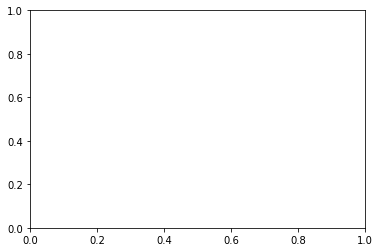

In [58]:
t = np.arange(0., 20.009, 0.01)

fig, ax = plt.subplots()
ax.plot(t, np.asarray(T_vhs_09_01), label=r'$T_{num}$ with $\tau=0.1$')
ax.plot(t, np.asarray(T_vhs_09_001),label=r'$T_{num}$ with $\tau=0.01$')
ax.plot(t,np.asarray(T_vhs_09_0001),label=r'$T_{num}$ with $\tau=0.001$')
# ax.plot(t, 2/(1 + 0.04*t)**2, label=r'$\frac{2}{(1+0.19058298t)^2}$')
# ax.plot(t, np.asarray(T_vhs_02), '-', label=r'$T_{num}$ with $e=0.2$')
# ax.plot(t, 2/(1.0 + 0.5159006*t)**2, label=r'$\frac{1}{(1+0.5159006t)^2}$')
ax.set_xlabel('$t$')
ax.set_ylabel('$T$')
ax.set_title('Haff\'s cooling law for $e=0.9$ with different $\tau$s.')
ax.legend()
ax.grid(which='both',linestyle=':')
# plt.savefig('heated_Haff_cooling_semilogy.pdf')
plt.show()

In [71]:
%%time
T_vhs_095 = [2]
for t in range(1,2001):
#     f = np.real(Q.ifft3(f_hat[t]))
    T_vhs_095.append((np.sum(fs[t]*Q.v_norm)*Q.dv**3 - 0.5)/3)

CPU times: user 141 ms, sys: 48.8 ms, total: 189 ms
Wall time: 187 ms


In [25]:
%%time
T_vhs_09 = [2]
for t in range(1,2001):
#     f = np.real(Q.ifft3(f_hat[t]))
    T_vhs_09.append((np.sum(fs[t]*Q.v_norm)*Q.dv**3 - 0.5)/3)

CPU times: user 131 ms, sys: 0 ns, total: 131 ms
Wall time: 129 ms


In [66]:
%%time
T_vhs_085 = [2]
for t in range(1,2001):
#     f = np.real(Q.ifft3(f_hat[t]))
    T_vhs_085.append((np.sum(fs[t]*Q.v_norm)*Q.dv**3 - 0.5)/3)

CPU times: user 152 ms, sys: 76.2 ms, total: 228 ms
Wall time: 227 ms


In [48]:
%%time
T_vhs_08 = [2]
for t in range(1,2001):
#     f = np.real(Q.ifft3(f_hat[t]))
    T_vhs_08.append((np.sum(fs[t]*Q.v_norm)*Q.dv**3 - 0.5)/3)

CPU times: user 154 ms, sys: 62.6 ms, total: 217 ms
Wall time: 215 ms


In [52]:
%%time
T_vhs_07 = [2]
for t in range(1,2001):
#     f = np.real(Q.ifft3(f_hat[t]))
    T_vhs_07.append((np.sum(fs[t]*Q.v_norm)*Q.dv**3 - 0.5)/3)

CPU times: user 172 ms, sys: 60.3 ms, total: 233 ms
Wall time: 231 ms


In [56]:
%%time
T_vhs_06 = [2]
for t in range(1,2001):
#     f = np.real(Q.ifft3(f_hat[t]))
    T_vhs_06.append((np.sum(fs[t]*Q.v_norm)*Q.dv**3 - 0.5)/3)

CPU times: user 184 ms, sys: 60.1 ms, total: 244 ms
Wall time: 242 ms


In [62]:
%%time
T_vhs_05 = [2]
for t in range(1, 2001):
#     f = np.real(Q.ifft3(f_hat[t]))
    T_vhs_05.append((np.sum(fs[t]*Q.v_norm)*Q.dv**3 - 0.5)/3)

CPU times: user 183 ms, sys: 55.2 ms, total: 238 ms
Wall time: 236 ms


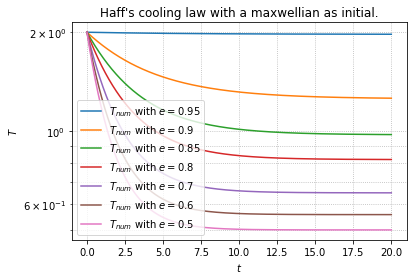

In [76]:
t = np.arange(0., 20.009, 0.01)

fig, ax = plt.subplots()
ax.semilogy(t, np.asarray(T_vhs_095), '-', label=r'$T_{num}$ with $e=0.95$')
ax.semilogy(t, np.asarray(T_vhs_09), '-', label=r'$T_{num}$ with $e=0.9$')
ax.semilogy(t, np.asarray(T_vhs_085), '-', label=r'$T_{num}$ with $e=0.85$')
ax.semilogy(t, np.asarray(T_vhs_08), '-', label=r'$T_{num}$ with $e=0.8$')
ax.semilogy(t, np.asarray(T_vhs_07), '-', label=r'$T_{num}$ with $e=0.7$')
ax.semilogy(t, np.asarray(T_vhs_06), '-', label=r'$T_{num}$ with $e=0.6$')
ax.semilogy(t, np.asarray(T_vhs_05), '-', label=r'$T_{num}$ with $e=0.5$')

# ax.plot(t, 2/(1 + 0.04*t)**2, label=r'$\frac{2}{(1+0.19058298t)^2}$')
# ax.plot(t, np.asarray(T_vhs_02), '-', label=r'$T_{num}$ with $e=0.2$')
# ax.plot(t, 2/(1.0 + 0.5159006*t)**2, label=r'$\frac{1}{(1+0.5159006t)^2}$')
ax.set_xlabel('$t$')
ax.set_ylabel('$T$')
ax.set_title('Haff\'s cooling law with a maxwellian as initial.')
ax.legend()
ax.grid(which='both',linestyle=':')
plt.savefig('heated_Haff_cooling_semilogy.pdf')
plt.show()

In [31]:
def T(t, e, eps, T_0):
    return (T_0 - 8*eps/(1-e**2))*np.exp(-(1-e**2)*t/4) + 8*eps/(1-e**2)

In [99]:
# e=0.2, 003
T(1, 0.2, eps, E_0*2/3) - E*2/3

0.2661413377541729

In [103]:
# e=0.2, 005
T(1, 0.2, eps, E_0*2/3) - E*2/3

0.16773023124809094

In [107]:
# e=0.2, 007
T(1, 0.2, eps, E_0*2/3) - E*2/3

0.10297536867238799

In [112]:
# e=0.2, 009
T(1, 0.2, eps, E_0*2/3) - E*2/3

0.02584202650005074

In [118]:
# e=0.2, 011
T(1, 0.2, eps, E_0*2/3) - E*2/3

-0.02422376071694199

In [122]:
# e=0.2, 013
T(1, 0.2, eps, E_0*2/3) - E*2/3

-0.003058799838901116

In [126]:
# e=0.2, 015
T(1, 0.2, eps, E_0*2/3) - E*2/3

0.004413127388460447

In [130]:
# e=0.2, 017
T(1, 0.2, eps, E_0*2/3) - E*2/3

-0.001220110856786194

In [134]:
# e=0.2, 019
T(1, 0.2, eps, E_0*2/3) - E*2/3

-0.000396517639616345

$T = 1$, $\Delta t = 0.01$ with anisotropic initial

| Spherical Design | 0.2 |
| ------ | ------ |
| 6 | 2.661413377541729e-01 | 
| 12 | 1.6773023124809094e-01 |
| 32 | 1.0297536867238799e-01 |
| 48 | 2.584202650005074e-02 |
| 70 | 2.422376071694199e-02 |
| 94 | 3.058799838901116e-03 |
| 120 | 4.413127388460447e-03 |
| 156 | 1.220110856786194e-03 |
| 192 | 3.96517639616345e-04 |

$T = 1$, $\Delta t = 0.01$ with isotropic initial

| Spherical Design | 0.2 |
| ------ | ------ |
| 6 | 0.0013957739849754791 | 
| 12 | 9.9706271716293315e-05 |
| 32 | 2.2499901350947482e-06 |
| 48 | 2.4272557155313734e-06 |
| 70 | 2.4703481364962698e-06 |
| 94 | 2.4703481364962698e-06 |
| 120 | 2.453380453903975e-06 | 